In [1]:
import cPickle, glob, h5py, os, string, matplotlib
#matplotlib.use('Agg')
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from imp import reload

from gabor_fit import fit

from oc_ica import plotting, analysis, styles

/home/jesse/anaconda3/envs/python27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# ICA

## 2x

In [2]:
folder = '/home/jesse/Development/results/oc_ica/nat_images_mixtures-64_sources-128'
files = sorted(glob.glob(os.path.join(folder, '*.h5')))
files = sorted([f for f in files if 'SC.h5' not in f])
models = [f.split('.')[0].split('-')[-1] for f in files]
n_mixtures = int(folder.split('-')[-2].split('_')[0])
n_sources = int(folder.split('-')[-1].split('_')[0])
print(models)

ws = np.full((len(models), 50, n_sources, n_mixtures), np.nan)
for ii, fname in enumerate(files):
    with h5py.File(fname) as f:
        ws[ii] = np.squeeze(f['W_fits'].value)

['2', '4', 'COULOMB', 'COULOMB_F', 'RANDOM', 'RANDOM_F', 'SM']


## 1x

In [10]:
folder = '/home/jesse/Development/results/oc_ica/nat_images_mixtures-64_sources-64'
files = sorted(glob.glob(os.path.join(folder, '*.h5')))
files = sorted([f for f in files if 'SC.h5' not in f])
models = ['2', '4', 'COULOMB', 'COULOMB_F', 'RANDOM', 'RANDOM_F', 'SM']
n_mixtures = int(folder.split('-')[-2].split('_')[0])
n_sources = int(folder.split('-')[-1].split('_')[0])
print(models)
with h5py.File(files[0]) as f:
    ws = np.squeeze(f['W_fits'].value)

['2', '4', 'COULOMB', 'COULOMB_F', 'RANDOM', 'RANDOM_F', 'SM']


## 3x

In [14]:
folder = '/home/jesse/Development/results/oc_ica/nat_images_mixtures-64_sources-192'
files = sorted(glob.glob(os.path.join(folder, '*.h5')))
files = sorted([f for f in files if 'SC.h5' not in f])
models = [f.split('.')[0].split('-')[-1] for f in files]
n_mixtures = int(folder.split('-')[-2].split('_')[0])
n_sources = int(folder.split('-')[-1].split('_')[0])
print(models)

ws = np.full((len(models), 10, n_sources, n_mixtures), np.nan)
for ii, fname in enumerate(files):
    with h5py.File(fname) as f:
        ws[ii] = np.squeeze(f['W_fits'].value)

['2', '4', 'COULOMB', 'COULOMB_F', 'RANDOM', 'RANDOM_F', 'SM']


In [ ]:
params = plotting.get_Gabor_params(ws[:, 0])
with open(os.path.basename(folder)+'.pkl', 'w') as f:
    cPickle.dump(params, f)

In [3]:
with open(os.path.basename(folder)+'.pkl', 'r') as f:
    params = cPickle.load(f)

# SC

In [29]:
#folder = '/home/jesse/Development/results/oc_ica/nat_images_mixtures-64_sources-64'
folder = '/home/jesse/Development/results/oc_ica/nat_images_mixtures-64_sources-128'
#folder = '/home/jesse/Development/results/oc_ica/nat_images_mixtures-64_sources-192'
files = sorted(glob.glob(os.path.join(folder, '*SC.h5')))
models = ['SC']
print(files)
n_mixtures = int(folder.split('-')[-2].split('_')[0])
n_sources = int(folder.split('-')[-1].split('_')[0])
print(models)

ws = np.full((len(models), 10, n_sources, n_mixtures), np.nan)
for ii, fname in enumerate(files):
    with h5py.File(fname) as f:
        ws[ii] = np.squeeze(f['W_fits'].value)
ws = ws[:, [5]]

['/home/jesse/Development/results/oc_ica/nat_images_mixtures-64_sources-128/nat_images_mixtures-64_sources-128_models-SC.h5']
['SC']


In [ ]:
params = plotting.get_Gabor_params(ws[0])
with open('{}_SC.pkl'.format(os.path.basename(folder)), 'w') as f:
    cPickle.dump(params, f)

In [30]:
with open('{}_SC.pkl'.format(os.path.basename(folder)), 'r') as f:
    params = cPickle.load(f)

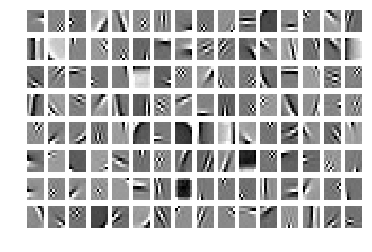

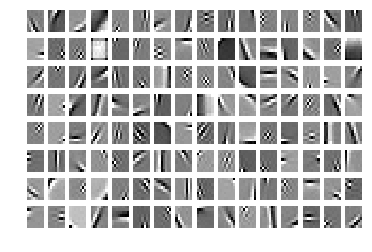

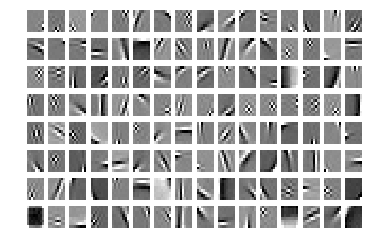

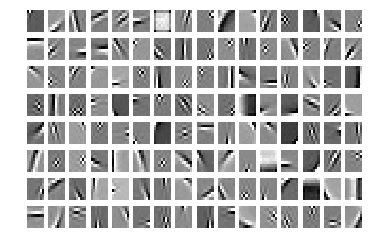

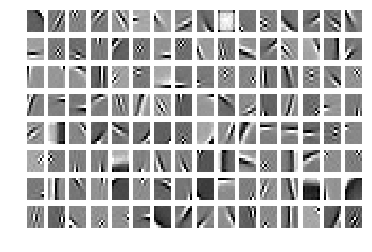

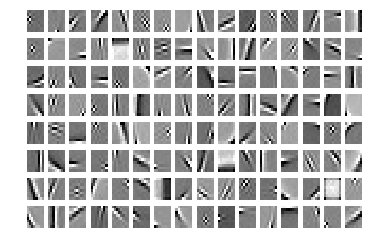

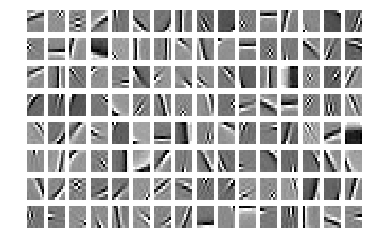

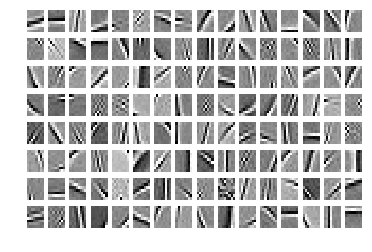

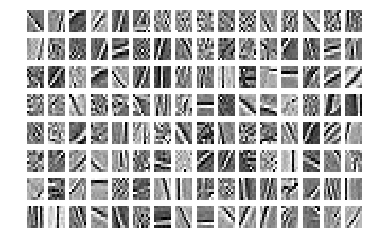

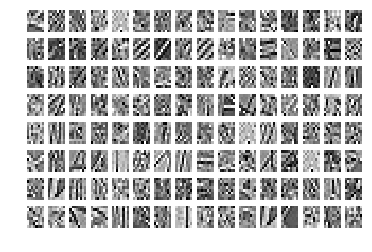

In [221]:
reload(plotting)
for ii in range(10):
    plotting.plot_bases(ws[0, ii])

# Continue

In [24]:
rng = np.random.RandomState(2017)
ws_null = ws[:, 0].copy()

for ii in range(ws_null.shape[0]):
    for jj in range(ws_null.shape[2]):
        order = rng.permutation(ws_null.shape[1])
        ws_null[ii, :, jj] = ws_null[ii, :, jj][order]
    ws_null[ii] = ws_null[ii]/np.linalg.norm(ws_null[ii], axis=1, keepdims=True)
params_null = plotting.get_Gabor_params(ws_null)

In [88]:
n_mixtures = 64

In [13]:
ws.shape

(7, 50, 128, 64)

(0.33476394849785407, 0.775, 0.2594420600858369)
(4, 3, 4)
('l', 2.828427, 13020.063, 2.8284287, 1146.0396)
('l', 2.828427, 13020.063, 2.8284287, 1146.0396)
[2.82842708 3.90829988]
(4, 3, 7)
(4, 3, 10)
(4, 3, 5)
('l', 2.828427, 17.187363, 2.9130116, 1.9649768)
('l', 2.828427, 17.187363, 2.9130116, 1.9649768)
[2.82842708 4.84809442]
(4, 3, 8)
(4, 3, 11)
(4, 3, 6)
('l', 2.828427, 15.119445, 2.915193, 2.2488341)
('l', 2.828427, 15.119445, 2.915193, 2.2488341)
[2.82842708 5.38366261]
(4, 3, 9)
(4, 3, 12)


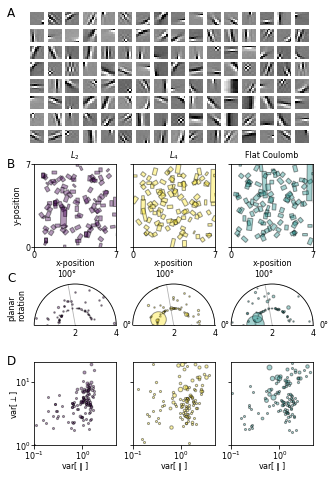

In [27]:
reload(plotting)
n = 0
idxs = [0, 1, 3]
modelsp = [models[ii] for ii in idxs]
f = plt.figure(figsize=((5./3)*len(modelsp), 7))
height_by_width = float(8 * 8 + 7 * 2) / float(16 * 8 + 7 * 15)
width = 1. - .225
height = height_by_width * width
print(height_by_width, width, height)
ax = f.add_axes([.1125, .725, width, height])

plotting.plot_bases(ws[4, 0], (f, ax))
for ii, m in zip(idxs, modelsp):
    labelx = True
    if n//3 == 0:
        labely = True
    else:
        labely = False
    pos = (4, len(modelsp), 3+n//len(modelsp)+1)
    plotting.plot_GaborFit_xy(params[ii][1], int(np.sqrt(n_mixtures)), m, f=f, pos=pos,
                              labelx=labelx, labely=labely)
    print pos
    n += 1
    pos = (4, len(modelsp), 3+n//len(modelsp)+4)
    plotting.plot_GaborFit_polar(params[ii][1], m, f=f, pos=pos,
                                 labelx=labelx, labely=False)
    print pos
    n += 1
    pos = (4, len(modelsp), 3+n//len(modelsp)+7)
    plotting.plot_GaborFit_envelope(params[ii][1], m, f=f, pos=pos,
                                    labelx=labelx, labely=labely)
    print pos
    n += 1
x = .05
f.text(x, .975, 'A', fontsize=styles.letter_fontsize)
f.text(x, .675, 'B', fontsize=styles.letter_fontsize)
f.text(x, .45, 'C', fontsize=styles.letter_fontsize)
f.text(x, .285, 'D', fontsize=styles.letter_fontsize)
f.text(x, .4, 'planar\nrotation', rotation='vertical', fontsize=styles.label_fontsize)
#plt.tight_layout()
plt.savefig('/home/jesse/Downloads/figure6.pdf')
plt.show()
plt.close()

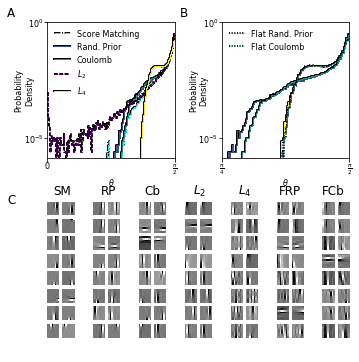

In [5]:
reload(plotting)
idxs1 = [6, 4, 2, 0, 1]
idxs2 = [1, 4, 5, 2, 3]
idxs3 = [6, 4, 2, 0, 1, 5, 3]
plotting.plot_figure4(ws[idxs1], [models[ii] for ii in idxs1],
                      ws[idxs2], [models[ii] for ii in idxs2],
                      ws[idxs3], [models[ii] for ii in idxs3],
                      save_path='/home/jesse/Downloads/figure5.pdf')

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(np.sqrt(1./params[0][2]))
ax1.set_title('data')

ax2.hist(np.sqrt(1./params_null[0][2]))
ax2.set_title('null')
plt.show()

In [31]:
fitter = fit.GaborFit()

In [28]:
n = 0

In [29]:
reload(plotting)
plotting.plot_bases(ws[n, 0])
wp = fitter.make_gabor(params[n][0][-1], 8, 8).T
wp = wp.reshape(wp.shape[0], -1)
plotting.plot_bases(wp)
plt.show()

NameError: name 'fitter' is not defined

In [34]:
reload(plotting)
plotting.plot_bases(ws_null[n])
wp = fitter.make_gabor(params_null[n][0][-1], 8, 8).T
wp = wp.reshape(wp.shape[0], -1)
plotting.plot_bases(wp)
plt.show()

In [214]:
ws.shape

(1, 10, 64, 64)

# Ringach comparison

In [4]:
db_rf = loadmat(os.path.join(os.environ['HOME'], 'Development/results/oc_ica/db_rf.mat'))

In [5]:
nx = db_rf['db'][0][0][0].ravel()
ny = db_rf['db'][0][0][1].ravel()
phase = db_rf['db'][0][0][2].ravel()

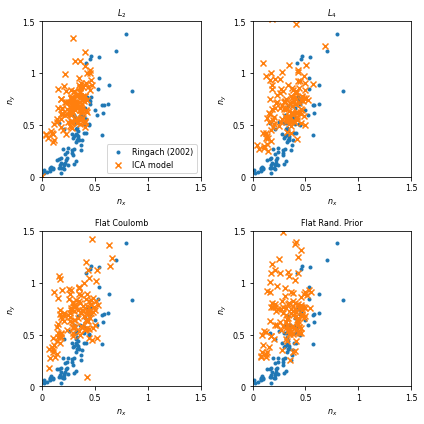

In [11]:
f, axes = plt.subplots(2, 2, figsize=(6, 6))
for ii, mi in enumerate([0, 1, 3, 5]):
    ax = axes.ravel()[ii]
    x, y, theta, phi, kx, vx, vy = fit.standardize_params(*params[mi][1])
    phi = phi - np.pi/2.
    phi = np.angle(np.abs(np.cos(phi)) + 1.j * np.abs(np.sin(phi)))
    ax.scatter(nx, ny, marker='.', label='Ringach (2002)')
    ax.scatter(kx*np.sqrt(vx) / (2. * np.pi), kx*np.sqrt(vy) / (2. * np.pi),
                marker='x', label='ICA model')
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 1.5)
    ax.set_xticks([0, .5, 1, 1.5])
    ax.set_xticklabels([0, .5, 1, 1.5], fontsize=styles.ticklabel_fontsize)
    ax.set_yticks([0, .5, 1, 1.5])
    ax.set_yticklabels([0, .5, 1, 1.5], fontsize=styles.ticklabel_fontsize)
    ax.set_xlabel(r'$n_x$', fontsize=styles.label_fontsize)
    ax.set_ylabel(r'$n_y$', fontsize=styles.label_fontsize)
    if ii == 0:
        ax.legend(loc='best', fontsize=styles.legend_fontsize)
    ax.set_title(styles.labels[models[mi]], fontsize=styles.label_fontsize)
    plt.tight_layout()
base_name = 'Downloads/nx_ny_nsources-{}_nmixtures-{}.pdf'
plt.savefig(os.path.join(os.environ['HOME'],
                         base_name.format(n_sources, n_mixtures)))

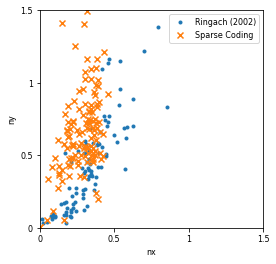

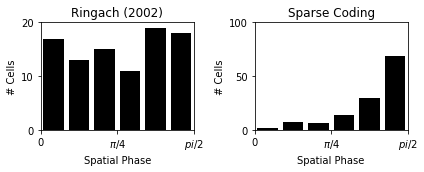

In [31]:
ii = 0
x, y, theta, phi, kx, vx, vy = fit.standardize_params(*params[ii][1])
phi = phi - np.pi/2.
phi = np.angle(np.abs(np.cos(phi)) + 1.j * np.abs(np.sin(phi)))

f, ax = plt.subplots(1, figsize=(4, 4))
ax.scatter(nx, ny, marker='.', label='Ringach (2002)')
ax.scatter(kx*np.sqrt(vx) / (2. * np.pi), kx*np.sqrt(vy) / (2. * np.pi),
            marker='x', label=styles.labels[models[ii]])
ax.set_xlim(0, 1.5)
ax.set_ylim(0, 1.5)
ax.set_xticks([0, .5, 1, 1.5])
ax.set_xticklabels([0, .5, 1, 1.5], fontsize=styles.ticklabel_fontsize)
ax.set_yticks([0, .5, 1, 1.5])
ax.set_yticklabels([0, .5, 1, 1.5], fontsize=styles.ticklabel_fontsize)
ax.set_xlabel('nx', fontsize=styles.label_fontsize)
ax.set_ylabel('ny', fontsize=styles.label_fontsize)
ax.legend(loc='best', fontsize=styles.legend_fontsize)
base_name = 'Downloads/nx_ny_Model-{}_nsources-{}_nmixtures-{}.pdf'
plt.savefig(os.path.join(os.environ['HOME'],
                         base_name.format(models[ii], n_sources, n_mixtures)))
f, axes = plt.subplots(1, 2, figsize=(6, 2.5))
for p, ax in zip([phase, phi], axes):
    bins = np.linspace(0, np.pi/2., 7)
    h, bins = np.histogram(p, bins=bins)
    x = np.linspace(0, np.pi/2, 13)[1::2]
    ax.bar(x, h, width = .8*(np.pi/12.), align='center', facecolor='k')
    ax.set_xticks([0, np.pi/4., np.pi/2.])
    ax.set_xticklabels([0, r'$\pi$/4', r'$pi$/2'])
    ax.set_xlabel('Spatial Phase')
    ax.set_ylabel('# Cells')
    ax.set_xlim(0, np.pi/2.)
axes[0].set_yticks([0, 10, 20])
axes[0].set_title('Ringach (2002)')
axes[1].set_yticks([0, 50, 100])
axes[1].set_title(styles.labels[models[ii]])
plt.tight_layout()
base_name = 'Downloads/phase_Model-{}_nsources-{}_nmixtures-{}.pdf'
plt.savefig(os.path.join(os.environ['HOME'],
                         base_name.format(models[ii], n_sources, n_mixtures)))

In [148]:
db_rf['db']

array([[(array([[0.25484503, 0.19679804, 0.16593522, 0.33302144, 0.08540133,
        0.01781183, 0.21640959, 0.35620999, 0.24253   , 0.52047428,
        0.57872889, 0.10235545, 0.58372026, 0.32253224, 0.39590378,
        0.31879979, 0.46486462, 0.44377479, 0.13952817, 0.3039056 ,
        0.28210805, 0.33833369, 0.36741816, 0.38658113, 0.41659991,
        0.39392364, 0.29135147, 0.21237081, 0.37015273, 0.02008764,
        0.4127328 , 0.07938429, 0.45240899, 0.53140236, 0.30858176,
        0.41779647, 0.31830282, 0.07698365, 0.22357576, 0.22082893,
        0.10176258, 0.24249997, 0.16403742, 0.53673617, 0.54113269,
        0.17482822, 0.34926358, 0.30624835, 0.24073975, 0.38058563,
        0.56834939, 0.29877024, 0.34305348, 0.33279031, 0.7023501 ,
        0.31913179, 0.44039495, 0.32652559, 0.45730256, 0.40392435,
        0.33959233, 0.62838653, 0.32761001, 0.79577554, 0.34445712,
        0.30241512, 0.28854622, 0.85445725, 0.49690648, 0.46793786,
        0.30008425, 0.20991307, 0.16489

# Score Matching

In [109]:
import os, h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import image

from oc_ica.datasets import zca
from oc_ica.utils import tile_raster_images as tri
from oc_ica.models import sc, ica
from oc_ica.plotting import plot_bases
from oc_ica.sparsity_search import sparsity_search
from oc_ica.optimizers.ica_optimizers import sgd, adam, momentum
reload(sc)
reload(ica)

<module 'oc_ica.models.ica' from '/home/jesse/Development/oc_ica/oc_ica/models/ica.pyc'>

In [110]:
filename = '/home/jesse/Development/data/vanhateren/images_curated.h5'
key = 'van_hateren_good'

with h5py.File(filename,'r') as f:
    images = f[key].value

In [111]:
patch_size = 8
n_mixtures = patch_size**2
OC = 1.
n_sources = int(n_mixtures * float(OC))
total_samples = 10 * n_mixtures * n_sources
rng = np.random.RandomState(20170125)
patches = image.PatchExtractor(patch_size=(patch_size, patch_size),
                               max_patches=total_samples//images.shape[0],
                               random_state=rng).transform(images)
X = patches.reshape((patches.shape[0],n_mixtures)).T
X_mean = X.mean(axis=-1, keepdims=True)
X -= X_mean
X_zca, d, u = zca(X)

In [116]:
m = ica.ICA
model, lambd, p = sparsity_search(m, 19., X_zca, degeneracy='Lp', p=4, rng=rng)

Complete ICA
Degeneracy control: L4
ICA with L-BFGS-B done!
Final loss value: 0.00210763304494
Complete ICA
Degeneracy control: L4
ICA with L-BFGS-B done!
Final loss value: 17679054.0
Complete ICA
Degeneracy control: L4
ICA with L-BFGS-B done!
Final loss value: 187.623886108
Complete ICA
Degeneracy control: L4
ICA with L-BFGS-B done!
Final loss value: 0.611315250397
Complete ICA
Degeneracy control: L4
ICA with L-BFGS-B done!
Final loss value: 10.7498865128


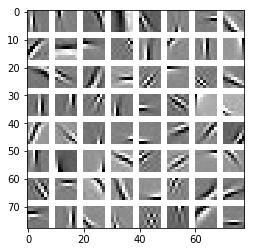

In [114]:
sq = int(np.ceil(np.sqrt(n_sources)))
im = tri(model.components_, (patch_size, patch_size), (sq, sq), (2, 2))
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.show()

# SM ICA

In [11]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
x, y = np.meshgrid(x, y)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

z = np.log(np.cosh(x)) + np.log(np.cosh(y))
z = z-z.min()
z = z/z.max()
ax1.contour(x, y, z, aspect='equal', cmap='viridis')
ax1.set_title('log(cosh(s))')
ax1.set_xlabel('s1')
ax1.set_ylabel('s2')

z = (-1+1.5*np.tanh(x)**2) + (-1+.5*np.tanh(y)**2)
z = z-z.min()
z = z/z.max()
ax2.contour(x, y, z, aspect='equal', cmap='viridis')
ax2.set_title('-1+.5tanh(s1)^2')
ax2.set_xlabel('s1')
ax2.set_ylabel('s2')

plt.tight_layout()
plt.show()